# Feature Engineering

<hr>

## Introduction

In this course you'll learn about one of the most important steps on the way to building a great machine learning model: feature engineering. You'll learn how to:

- determine which features are the most important with mutual information
- invent new features in several real-world problem domains
- encode high-cardinality categoricals with a target encoding
- create segmentation features with k-means clustering
- decompose a dataset's variation into features with principal component analysis

In [33]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

concrete = pd.read_csv("concrete.csv")

**The ```.pop()``` method returns removed value from the list**

Establishing baselines like this is good practice at the start of the feature engineering process. A baseline score can help you decide whether your new features are worth keeping, or whether you should discard them and possibly try something else.

In [35]:
X = concrete.copy()

y = X.pop("CompressiveStrength")

# Train and score baseline model
baseline = RandomForestRegressor(criterion="absolute_error", random_state=0)
baseline_score = cross_val_score(
    baseline, X, y, cv=5, scoring="neg_mean_absolute_error"
)
baseline_score = -1 * baseline_score.mean()

print(f"MAE Baseline Score: {baseline_score:.4}")

MAE Baseline Score: 8.232


If you ever cook at home, you might know that the ratio of ingredients in a recipe is usually a better predictor of how the recipe turns out than their absolute amounts. We might reason then that ratios of the features above would be a good predictor of ```CompressiveStrength```

In [36]:
X = concrete.copy()
y = X.pop("CompressiveStrength")

# Create synthetic features
X["FCRatio"] = X["FineAggregate"] / X["CoarseAggregate"]
X["AggCmtRatio"] = (X["CoarseAggregate"] + X["FineAggregate"]) / X["Cement"]
X["WtrCmtRatio"] = X["Water"] / X["Cement"]

# Train and score model on dataset with additional ratio features
model = RandomForestRegressor(criterion="absolute_error", random_state=0)
score = cross_val_score(
    model, X, y, cv=5, scoring="neg_mean_absolute_error"
)
score = -1 * score.mean()

print(f"MAE Score with Ratio Features: {score:.4}")

MAE Score with Ratio Features: 7.948


<hr>

## Mutual Information

The mutual information (MI) between two quantities is a measure of the extent to which knowledge of one quantity reduces uncertainty about the other. If you knew the value of a feature, how much more confident would you be about the target?

**Interpreting Mutual Information Scores**

The least possible mutual information between quantities is 0.0. When MI is zero, the quantities are independent: neither can tell you anything about the other. Conversely, in theory there's no upper bound to what MI can be. In practice though values above 2.0 or so are uncommon. (Mutual information is a logarithmic quantity, so it increases very slowly.)

**Here are some things to remember when applying mutual information:**

- MI can help you to understand the relative potential of a feature as a predictor of the target, considered by itself.
- It's possible for a feature to be very informative when interacting with other features, but not so informative all alone. MI can't detect interactions between features. It is a univariate metric.
- The actual usefulness of a feature depends on the model you use it with. A feature is only useful to the extent that its relationship with the target is one your model can learn. Just because a feature has a high MI score doesn't mean your model will be able to do anything with that information. You may need to transform the feature first to expose the association.

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
print(plt.style.available)
plt.style.use('seaborn-v0_8-whitegrid')

auto = pd.read_csv("autos.csv")
auto.head()

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


,symboling,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,length,...,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,3,alfa-romero,gas,std,2,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9,111,5000,21,27,13495
1,3,alfa-romero,gas,std,2,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9,111,5000,21,27,16500
2,1,alfa-romero,gas,std,2,hatchback,rwd,front,94.5,171.2,...,152,mpfi,2.68,3.47,9,154,5000,19,26,16500
3,2,audi,gas,std,4,sedan,fwd,front,99.8,176.6,...,109,mpfi,3.19,3.40,10,102,5500,24,30,13950
4,2,audi,gas,std,4,sedan,4wd,front,99.4,176.6,...,136,mpfi,3.19,3.40,8,115,5500,18,22,17450


- ```X[colname].factorize()```: This function encodes the categorical values as integers. Each unique value in the column is assigned a unique integer. For example, if a column has values ```["cat", "dog", "cat"]```, after factorization, it might be encoded as ```[0, 1, 0]```.
- ```X[colname], _```: The ```factorize()``` method returns two values: the encoded values and an array of the unique values that were found (the factorization "categories"). The underscore ```_``` is used to ignore the second returned value because we don't need the array of unique values in this context.

In [38]:
X = auto.copy()
y = X.pop("price")

# Label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = X.dtypes == int

Scikit-learn has two mutual information metrics in its ```feature_selection``` module: one for real-valued targets ```(mutual_info_regression)``` and one for categorical targets ```(mutual_info_classif)```. Our target, ```price```, is real-valued. The next cell computes the MI scores for our features and wraps them up in a nice dataframe.

In [39]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores[::3]  # show a few features with their MI scores

curb_weight          0.915233
highway_mpg          0.891423
length               0.608552
fuel_system          0.465062
drive_wheels         0.332695
symboling            0.225678
compression_ratio    0.104811
fuel_type            0.048120
Name: MI Scores, dtype: float64

**Visualizing**

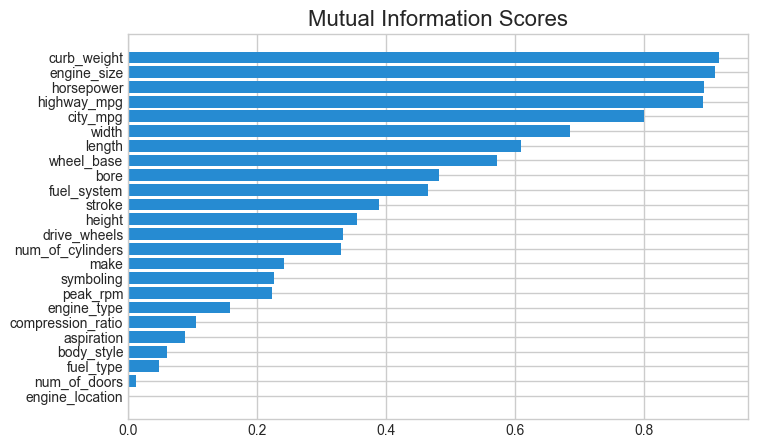

In [40]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

<hr>

## Creating Features

In the Automobile dataset are features describing a car's engine. Research yields a variety of formulas for creating potentially useful new features. The "stroke ratio", for instance, is a measure of how efficient an engine is versus how performant:

In [42]:
auto["stroke_ratio"] = auto.stroke / auto.bore

auto[["stroke", "bore", "stroke_ratio"]].head()

,stroke,bore,stroke_ratio
0,2.68,3.47,0.772334
1,2.68,3.47,0.772334
2,3.47,2.68,1.294776
3,3.40,3.19,1.065831
4,3.40,3.19,1.065831


Data visualization can suggest transformations, often a "reshaping" of a feature through powers or logarithms. The distribution of WindSpeed in US Accidents is highly skewed, for instance. In this case the logarithm is effective at normalizing it

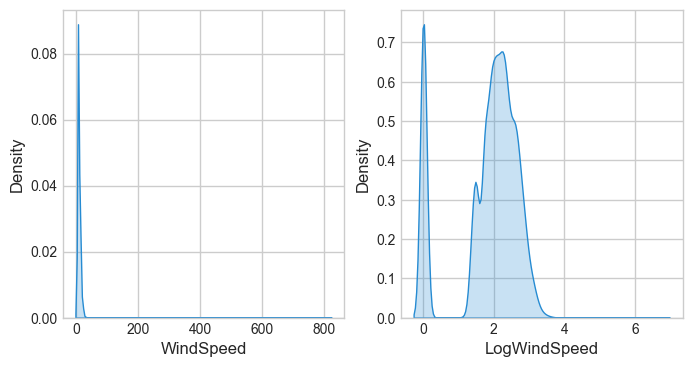

In [45]:
accidents = pd.read_csv("accidents.csv")

# If the feature has 0.0 values, use np.log1p (log(1+x)) instead of np.log
accidents["LogWindSpeed"] = accidents.WindSpeed.apply(np.log1p)

# Plot a comparison
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
sns.kdeplot(accidents.WindSpeed, fill=True, ax=axs[0])
sns.kdeplot(accidents.LogWindSpeed, fill=True, ax=axs[1]);